In [1]:
# %pip install textblob nltk pandas seaborn matplotlib scikit-learn

In [1]:
# It is assumed the behaviour.xlsx file contains column headings Id, date, content, username, media, company

import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Load the Excel file
file_path = "Behaviour.xlsx"
df = pd.read_excel(file_path)

In [3]:
# Set the 'id' column as the index
df.set_index("id", inplace=True)
df.shape

(300000, 6)

In [4]:
df.head()

,date,likes,content,username,media,inferred company
id,,,,,,
1,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons
2,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
3,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc
4,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
5,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent


In [5]:
df.isna().sum()
# No columns with missing values

date                0
likes               0
content             0
username            0
media               0
inferred company    0
dtype: int64

In [6]:
df.rename(columns={"inferred company": "inferred_company"}, inplace=True)
df.head()

,date,likes,content,username,media,inferred_company
id,,,,,,
1,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons
2,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
3,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc
4,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
5,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent


In [34]:
company_rankings = pd.read_csv('brandirectory-ranking-data-global-2024.csv')
company_rankings = company_rankings['Brand'].apply(lambda x: x.lower())
company_rankings.to_numpy()

array(['apple', 'microsoft', 'google', 'amazon', 'samsung group',
       'walmart', 'tiktok/douyin', 'facebook', 'deutsche telekom', 'icbc',
       'verizon', 'state grid corporation of china', 'instagram',
       'china construction bank', 'starbucks',
       'agricultural bank of china', 'mercedes-benz', 'tesla', 'oracle',
       'home depot', 'toyota', 'bank of china', 'shell', 'moutai', 'at&t',
       'costco', 'unitedhealthcare', 'allianz group', 'disney', 'nvidia',
       'ping an', 'china mobile', 'porsche', 'wechat', 'deloitte',
       'aramco', 'bmw', 'accenture', "mcdonald's", 'bank of america',
       'hyundai group', 'american express', 'tencent', 'wells fargo',
       'chase', 'mitsubishi group', 'coca-cola', 'ups', 'volkswagen',
       'marlboro', 'mitsui', 'louis vuitton', 'youtube', 'citi', 'huawei',
       'ntt group', 'ey', 'j.p. morgan', 'cvs', 'xfinity', 'cscec',
       'nike', 'uber', 'tata group', 'fedex', 'petrochina',
       'sinopec group', 'visa', 'spectrum', 

In [33]:
df['inferred_company'].unique()

array(['tim hortons', 'independent', 'cbc', 'williams', 'cnn', 'cisco',
       'getty images', 'mcafee', 'trane', 'pfizer', 'toyota', 'bell',
       'walmart', 'general motors', 'mayo clinic', 'nokia', 'desjardins',
       'ups', 'monster', 'united rentals', 'aaa', 'hobby lobby',
       'bacardi', 'amc', 'amway', 'shoprite', 'oracle',
       'turkish airlines', 'shell', 'free', 'microsoft', 'cameron',
       'sabc', 'emerson', 'bayer', 'heineken', 'samsung', 'no', 'td',
       'target', 'qatar airways', 'hudson', 'metro', 'ericsson',
       'peugeot', 'pepsico', 'avon', 'opel', 'amazon',
       'national geographic', 'mtn', 'comcast', 'icici bank', 'asus',
       'rona', 'arm', 'little caesars pizza', 'staples', 'scotiabank',
       'blackberry', 'padi', 'lane bryant', 'lenovo', 'bar', 'wwf',
       'mastercard', 'spotify', 'groupon', 'red bull', 'greenpeace',
       'harris teeter', 'aa', 'paramount pictures', 'virgin media',
       'urban outfitters', 'john deere', 'paytm', 'sap',
  

In [22]:
df['ranking'] = df['inferred_company'].apply(lambda x: company_rankings[company_rankings == x.lower()].index[0] if x.lower() in company_rankings.values else None)

In [7]:
# We ignore the date, likes and id because they don't contribute to the similarity of a tweet.
df_filtered = df[
    ~df.duplicated(subset=["content", "username", "media", "inferred_company"])
].reset_index(drop=True)
df_filtered.shape

(297605, 6)

In [8]:
# Check the shape of the cleaned DataFrame to see the difference
print("Shape of original DataFrame:", df.shape)
print("Shape of cleaned DataFrame:", df_filtered.shape)
df = df_filtered

Shape of original DataFrame: (300000, 6)
Shape of cleaned DataFrame: (297605, 6)


In [9]:
df["date"] = pd.to_datetime(df["date"])
df.head()

,date,likes,content,username,media,inferred_company
0,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons
1,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
2,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc
3,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
4,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent


In [10]:
class Media:
    media = None

    def __init__(self, body: str):
        self.media = list()
        body = re.sub(r"[\[\]\s]", "", body)
        video_content = list()
        for stream in body.split("),"):
            if stream.startswith("Photo"):
                self.media.append(Photo(stream))
            elif stream.startswith("Video"):
                video_content.append(stream)
            elif stream.startswith("duration"):
                self.media.append(Video(video_content, stream))
                video_content.clear()
            elif stream.startswith("Gif"):
                self.media.append(GIF(stream))
            else:
                print("Media parse error:", stream)

    def __str__(self):
        return str(vars(self))

    def __repr__(self) -> str:
        return str(self)


class Photo:
    preview_url = None
    full_url = None

    @staticmethod
    def get_category():
        return "photo"

    def __init__(self, body: str):
        self.preview_url = body.split("'")[1]
        self.full_url = body.split("'")[3]

    def __str__(self):
        item = vars(self)
        item["category"] = self.get_category()
        return str(item)

    def __repr__(self) -> str:
        return str(self)


class Video:
    thumbnail_url = None
    variants = None
    views = None
    duration = None

    @staticmethod
    def get_category():
        return "video"

    def __init__(self, body: list[str], last_stream: str):
        self.variants = list()
        self.thumbnail_url = body[0].split("'")[1]
        views = last_stream.split("views=")[1].split(")")[0]
        self.views = int(views) if views.isdigit() else None
        self.duration = float(last_stream.split("duration=")[1].split(",")[0])
        for stream in body:
            self.variants.append(VideoVarient(stream))

    def __str__(self):
        item = vars(self)
        item["category"] = self.get_category()
        return str(item)

    def __repr__(self) -> str:
        return str(self)


class VideoVarient:
    url = None
    content_type = None
    bitrate = None

    def __init__(self, body: str):
        body = body.split("VideoVariant(")[1]
        self.url = body.split("'")[3]
        self.content_type = body.split("'")[1]
        bitrate = body.split("bitrate=")[1].split(")")[0]
        self.bitrate = int(bitrate) if bitrate.isdigit() else None

    def __str__(self):
        item = vars(self)
        return str(item)

    def __repr__(self) -> str:
        return str(self)


class GIF:
    thumbnail_url = None
    full_url = None

    @staticmethod
    def get_category():
        return "gif"

    def __init__(self, body: str):
        self.thumbnail_url = body.split("'")[1]
        self.full_url = body.split("'")[-2]

    def __str__(self):
        item = vars(self)
        item["category"] = self.get_category()
        return str(item)

    def __repr__(self) -> str:
        return str(self)

In [11]:
df["media"] = df["media"].astype("object")
df["media"] = df["media"].apply(lambda x: Media(x).media)
df["media"].head()

0    [{'preview_url': 'https://pbs.twimg.com/media/...
1    [{'preview_url': 'https://pbs.twimg.com/media/...
2    [{'preview_url': 'https://pbs.twimg.com/media/...
3    [{'preview_url': 'https://pbs.twimg.com/media/...
4    [{'preview_url': 'https://pbs.twimg.com/media/...
Name: media, dtype: object

In [12]:
# Assuming df is your DataFrame and 'tweet' is the column with the tweet text
df['hashtags'] = df['content'].str.findall(r'#(\w+)')
df_exploded = df.explode('hashtags').dropna()
df_exploded['hashtags'] = df_exploded['hashtags'].apply(lambda x: x.lower())

In [13]:
df_exploded['hashtags'].unique().__len__()

45553

In [14]:
a = df_exploded.groupby('hashtags')['inferred_company'].unique()
hashtag_population = a[a.apply(lambda x: len(x) > 3)]
popular_hashtags = df_exploded[df_exploded['hashtags'].isin(hashtag_population.index)]

sorted_popular_hashtags = popular_hashtags.groupby('hashtags')['likes'].describe().sort_values(by='50%', ascending=False)[:100]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 [Text(0, 0, 'messi'),
  Text(1, 0, 'army'),
  Text(2, 0, 'twice'),
  Text(3, 0, 'exo'),
  Text(4, 0, 'cfc'),
  Text(5, 0, 'map_of_the_soul_persona'),
  Text(6, 0, 'game'),
  Text(7, 0, 'btsarmy'),
  Text(8, 0, 'jhope'),
  Text(9, 0, 'gucci'),
  Text(10, 0, 'blackpink'),
  Text(11, 0, 'shawnmendesthealbum'),
  Text(12, 0, 'yummy'),
  Text(13, 0, 'bts'),
  Text(14, 0, 'nct'),
  Text(15, 0, 'lover'),
  Text(

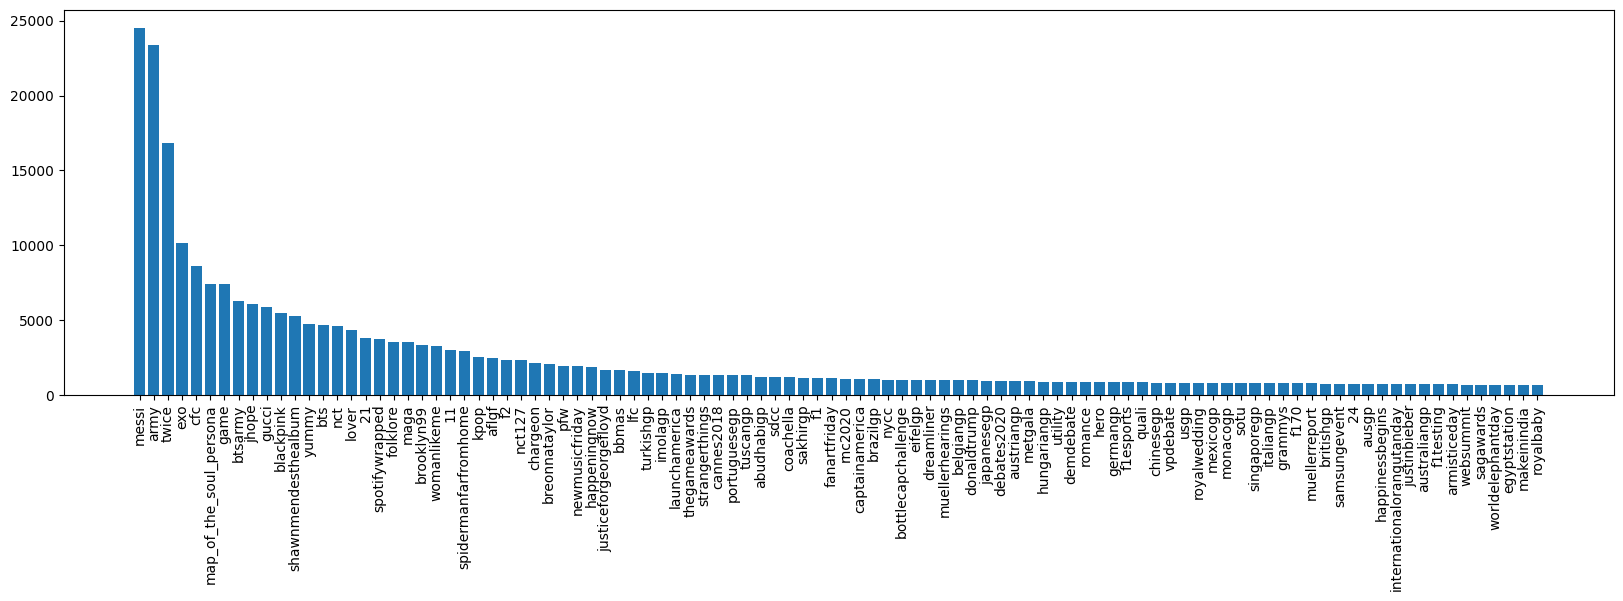

In [15]:
plt.figure(figsize=(20, 5))
plt.bar(sorted_popular_hashtags.index, sorted_popular_hashtags['50%'])
plt.xticks(rotation=90)

In [14]:
def normalize_text(text):
    # Remove emoticons and unwanted symbols
    text = re.sub(
        r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001F200-\U0001F2FF]+",
        "",
        text,
    )

    # Remove hashtags
    text = re.sub(r"#\w+", "", text)

    # Remove unwanted text
    text = re.sub(r"RT @\w+: ", "", text)

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    return text

In [15]:
# Normalise the tweet text
df["content"] = df["content"].apply(normalize_text)
df.head()

,date,likes,content,username,media,inferred_company
0,2020-12-12 00:47:00,1,Spend your weekend morning with a Ham Egg and ...,TimHortonsPH,[{'preview_url': 'https://pbs.twimg.com/media/...,tim hortons
1,2018-06-30 10:04:20,2750,Watch rapper mention freestyle for over an HOU...,IndyMusic,[{'preview_url': 'https://pbs.twimg.com/media/...,independent
2,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[{'preview_url': 'https://pbs.twimg.com/media/...,cbc
3,2020-10-01 11:40:09,152,1st in Europe to be devastated by COVID19 Ital...,MKWilliamsRome,[{'preview_url': 'https://pbs.twimg.com/media/...,williams
4,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of mention S...,BGISD,[{'preview_url': 'https://pbs.twimg.com/media/...,independent


In [16]:
def cleanup_text(text):
    # Remove extra whitespaces
    text = re.sub("\s+", " ", text)

    # Convert text to lowercase
    text = text.lower()

    # Remove leading and trailing whitespaces
    text = text.strip()

    return text

In [17]:
df["content"] = df["content"].apply(cleanup_text)
df.head()

,date,likes,content,username,media,inferred_company
0,2020-12-12 00:47:00,1,spend your weekend morning with a ham egg and ...,TimHortonsPH,[{'preview_url': 'https://pbs.twimg.com/media/...,tim hortons
1,2018-06-30 10:04:20,2750,watch rapper mention freestyle for over an hou...,IndyMusic,[{'preview_url': 'https://pbs.twimg.com/media/...,independent
2,2020-09-29 19:47:28,57,canadian armenian community demands ban on mil...,CBCCanada,[{'preview_url': 'https://pbs.twimg.com/media/...,cbc
3,2020-10-01 11:40:09,152,1st in europe to be devastated by covid19 ital...,MKWilliamsRome,[{'preview_url': 'https://pbs.twimg.com/media/...,williams
4,2018-10-19 14:30:46,41,congratulations to pauletha butts of mention s...,BGISD,[{'preview_url': 'https://pbs.twimg.com/media/...,independent


In [18]:
# We create a new feature, `content_length`
df["content_length"] = df["content"].apply(lambda x: len(x))

In [19]:
# Calculate measures of spread
variance = df["content_length"].var()
standard_deviation = df["content_length"].std()
interquartile_range = df["content_length"].quantile(0.75) - df[
    "content_length"
].quantile(0.25)

print("Stats about the content length")
print("\tVariance:", variance)
print("\tStandard Deviation:", standard_deviation)
print("\tInterquartile Range:", interquartile_range)

Stats about the content length
	Variance: 4280.883079654461
	Standard Deviation: 65.42845772027995
	Interquartile Range: 98.0


In [20]:
df["content_length"].describe()

count    297605.000000
mean        127.504185
std          65.428458
min          14.000000
25%          76.000000
50%         115.000000
75%         174.000000
max         435.000000
Name: content_length, dtype: float64

Text(0.5, 1.0, 'Tweets over time')

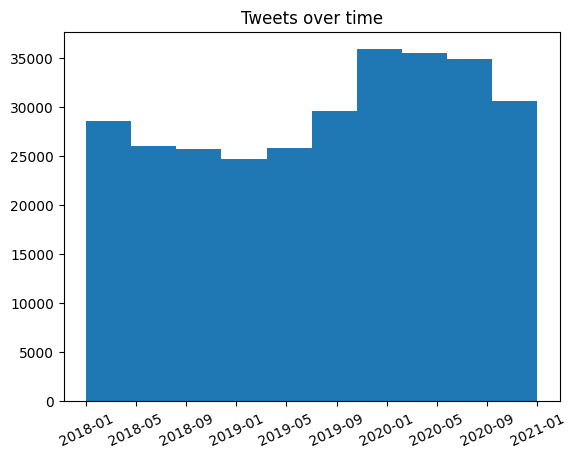

In [30]:
# Put plt.show() at the end to display the plot properly
plt.hist(df["date"].dt.date)
plt.xticks(rotation=25)
plt.title("Tweets over time")

Text(0.5, 1.0, 'Average tweet likes over time')

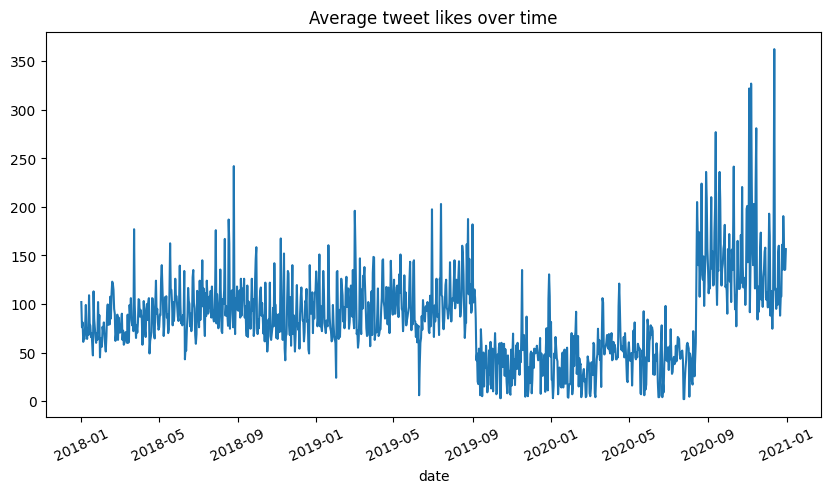

In [137]:
# Line graph
# Put plt.show() at the end to display the plot properly
temp_df = pd.DataFrame([df["date"].dt.date, df["likes"]]).T
temp_df.groupby("date")["likes"].median().plot(
    kind="line", figsize=(10, 5))
plt.xticks(rotation=25)
plt.title("Median tweet likes over time")

Text(0.5, 1.0, 'Average tweet length over time')

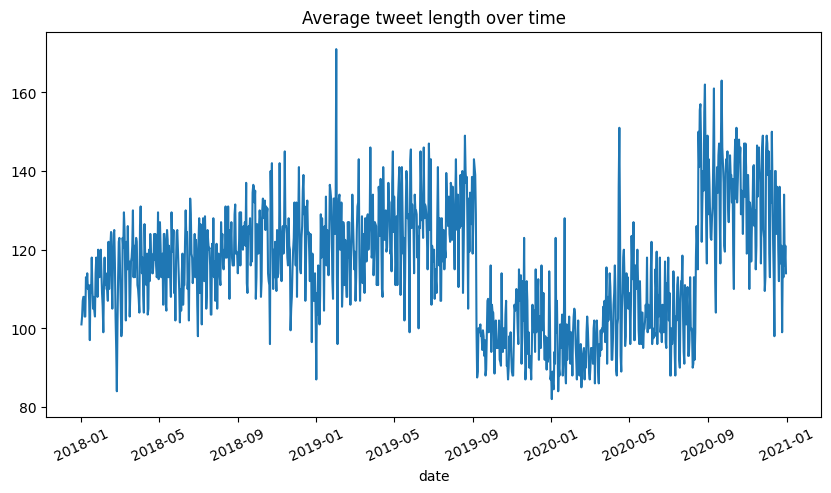

In [138]:
# Line graph
# Put plt.show() at the end to display the plot properly
temp_df = pd.DataFrame([df["date"].dt.date, df["content_length"]]).T
temp_df.groupby("date")["content_length"].median().plot(
    kind="line", figsize=(10, 5))
plt.xticks(rotation=25)
plt.title("Median tweet length over time")

Text(0.5, 1.0, 'Bar Graph of Company Counts')

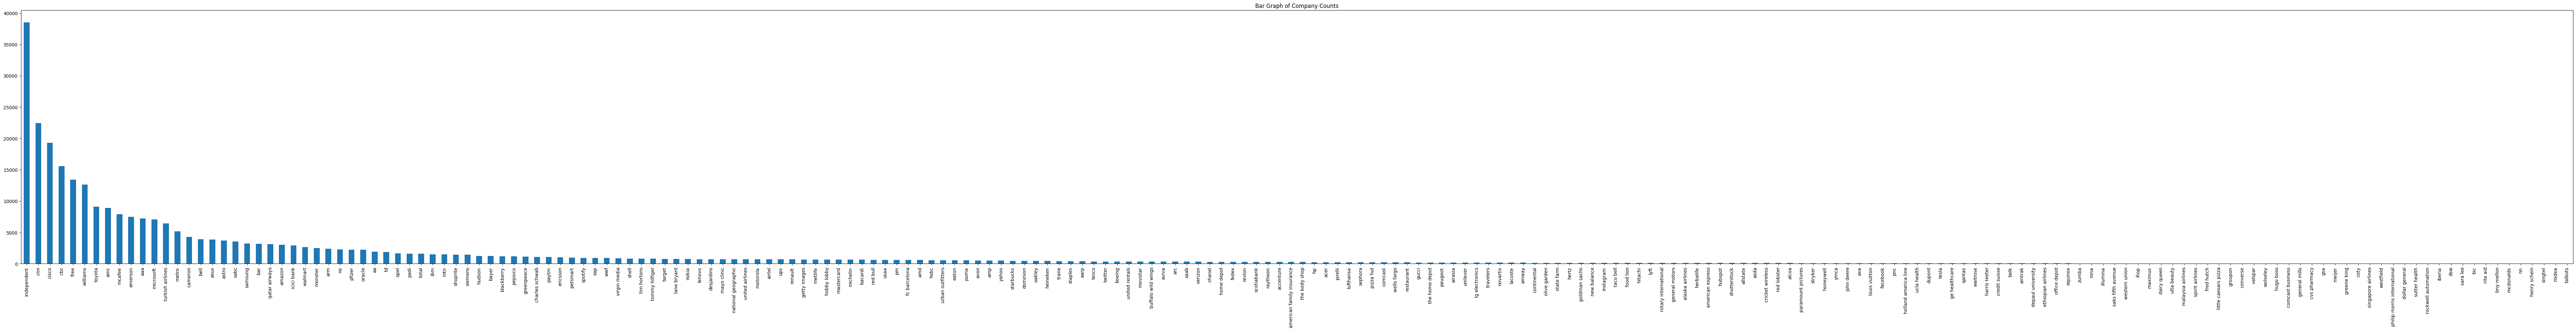

In [32]:
# Bar graph
# Put plt.show() at the end to display the plot properly
df["inferred_company"].value_counts().plot(kind="bar", figsize=(100, 10))
plt.title("Bar Graph of Company Counts")

Text(0.5, 1.0, 'Scatter Plot of Likes vs. Content Length')

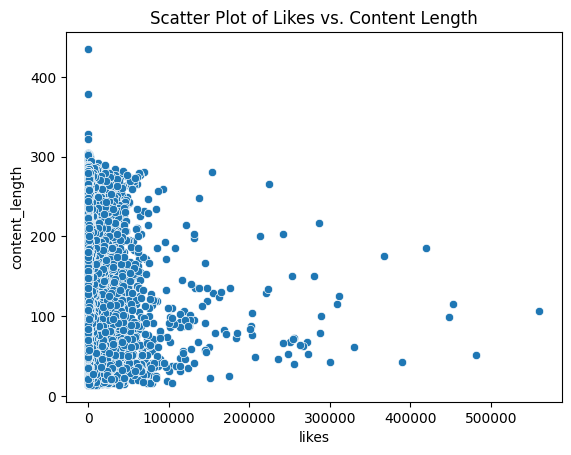

In [100]:
# Scatter plot
# Put plt.show() at the end to display the plot properly
sns.scatterplot(data=df, x="likes", y="content_length")
plt.title("Scatter Plot of Likes vs. Content Length")

# This graph shows that content_length alone is not a good predictor of likes (a lot of y-variance around likes = 0),
# BUT, if you have other "good" factors, then it helps to have $`median` amount of content_length. 

In [101]:
media_types = df["media"].apply(
    lambda x: set(map(lambda y: y.get_category(), x)))
media_types.value_counts()

{photo}           209978
{video}            74785
{gif}              12839
{photo, gif}           1
{photo, video}         1
{gif, video}           1
Name: media, dtype: int64

Text(0.5, 1.0, 'Pie Chart of Media Types')

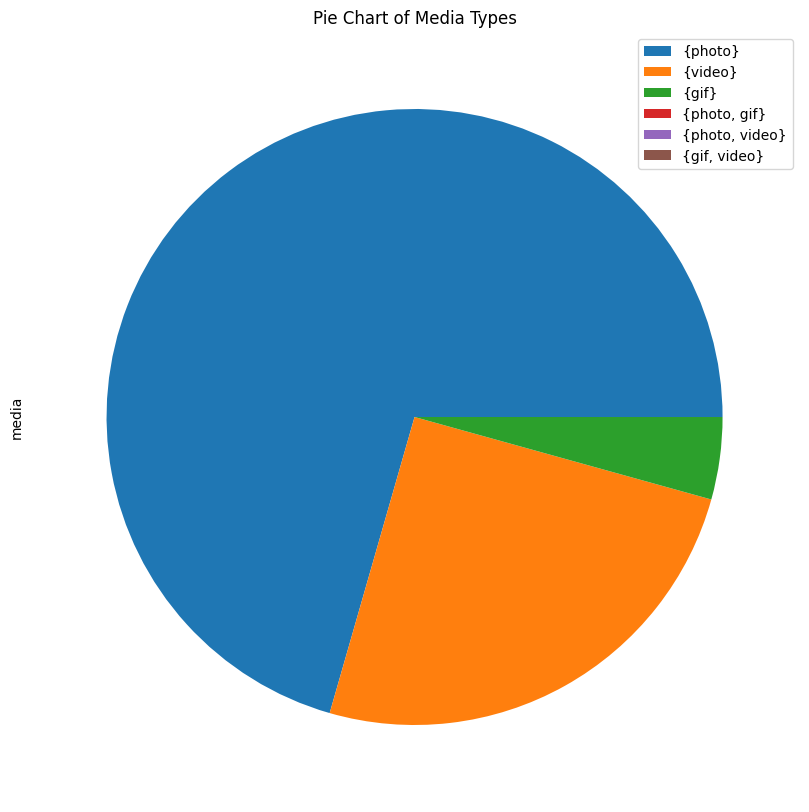

In [35]:
# Pie chart
# Put plt.show() at the end to display the plot properly

media_types.value_counts().plot(kind="pie", labels=None, legend=True, figsize=(20, 10))
plt.title("Pie Chart of Media Types")

In [102]:
df["media_type"] = media_types
df.head()

,date,likes,content,username,media,inferred_company,content_length,media_type
0,2020-12-12 00:47:00,1,spend your weekend morning with a ham egg and ...,TimHortonsPH,[{'preview_url': 'https://pbs.twimg.com/media/...,tim hortons,155,{photo}
1,2018-06-30 10:04:20,2750,watch rapper mention freestyle for over an hou...,IndyMusic,[{'preview_url': 'https://pbs.twimg.com/media/...,independent,67,{photo}
2,2020-09-29 19:47:28,57,canadian armenian community demands ban on mil...,CBCCanada,[{'preview_url': 'https://pbs.twimg.com/media/...,cbc,100,{photo}
3,2020-10-01 11:40:09,152,1st in europe to be devastated by covid19 ital...,MKWilliamsRome,[{'preview_url': 'https://pbs.twimg.com/media/...,williams,125,{photo}
4,2018-10-19 14:30:46,41,congratulations to pauletha butts of mention s...,BGISD,[{'preview_url': 'https://pbs.twimg.com/media/...,independent,164,{photo}


In [103]:
df["media_type"] = df["media_type"].apply(lambda x: str(x))

Text(0.5, 0, 'Media Type')

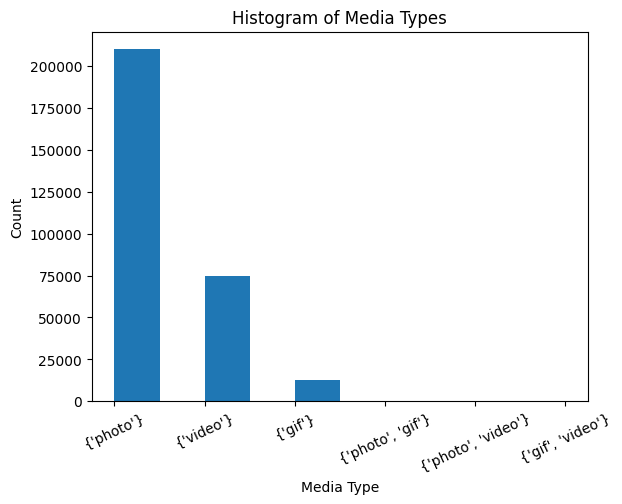

In [104]:
plt.hist(df["media_type"])
plt.xticks(rotation=25)
plt.title("Histogram of Media Types")
plt.ylabel("Count")
plt.xlabel("Media Type")

In [105]:
df.groupby("media_type")[["likes", "content_length"]].median()

,likes,content_length
media_type,,
"{'gif', 'video'}",1.0,116.0
{'gif'},86.0,86.0
"{'photo', 'gif'}",3.0,95.0
"{'photo', 'video'}",0.0,193.0
{'photo'},53.0,112.0
{'video'},184.0,129.0


In [106]:
df.groupby("media_type")[["likes", "content_length"]].mean()

,likes,content_length
media_type,,
"{'gif', 'video'}",1.000000,116.000000
{'gif'},748.260846,103.075084
"{'photo', 'gif'}",3.000000,95.000000
"{'photo', 'video'}",0.000000,193.000000
{'photo'},558.295536,125.657797
{'video'},1361.932259,136.882062


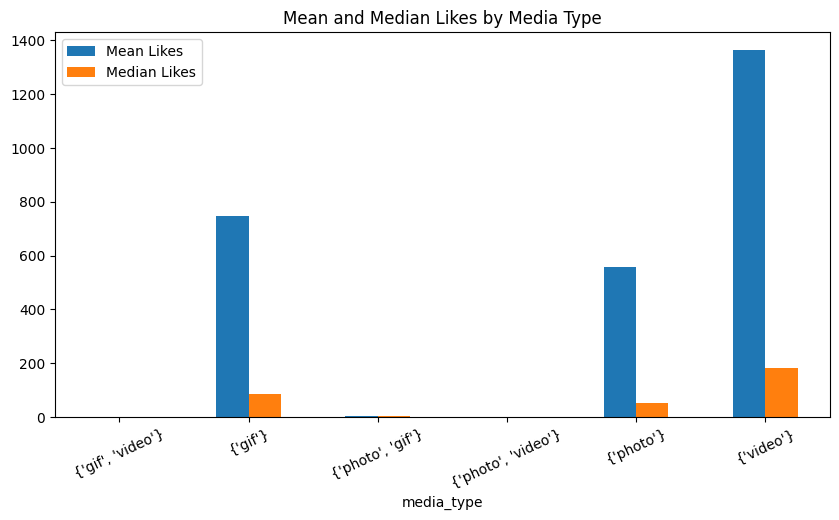

In [107]:
mean_likes = df.groupby("media_type")[["likes"]].mean()
median_likes = df.groupby("media_type")[["likes"]].median()

likes_df = mean_likes.join(median_likes, lsuffix="_mean", rsuffix="_median")

likes_df.plot(kind="bar", figsize=(10, 5))
plt.xticks(rotation=25)
plt.title("Mean and Median Likes by Media Type")
plt.legend(["Mean Likes", "Median Likes"])

In [108]:
# lets talk about videos
video_df = df[df["media_type"] == "{'video'}"]
video_df.reset_index(drop=True, inplace=True)
video_df.head()

,date,likes,content,username,media,inferred_company,content_length,media_type
0,2020-11-15 16:01:08,525,an 85yearold primary school in shanghai has be...,cnni,[{'variants': [{'url': 'https://video.twimg.co...,cnn,168,{'video'}
1,2018-07-17 22:04:26,3,next week cncf will be publishing a series of ...,CiscoCloud,[{'variants': [{'url': 'https://video.twimg.co...,cisco,196,{'video'}
2,2020-03-01 15:48:46,672,the ustaliban agreement which sets into motion...,CNN,[{'variants': [{'url': 'https://video.twimg.co...,cnn,263,{'video'}
3,2018-08-17 13:00:18,2,whilst is not found in the uk it can occur in ...,Pfizer_UK,[{'variants': [{'url': 'https://video.twimg.co...,pfizer,123,{'video'}
4,2019-04-16 16:49:47,233,wow what an experience complete with in flight...,townsendbell,[{'variants': [{'url': 'https://video.twimg.co...,bell,109,{'video'}


In [109]:
vid_durations = video_df["media"].apply(lambda x: x[0].duration)
vid_durations.head()

0     65.432
1     57.758
2    288.622
3     25.040
4      6.338
Name: media, dtype: float64

/tmp/ipykernel_198194/2189414784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_df["duration_bins"] = pd.qcut(vid_durations, q=7)


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, '(0.616, 10.733]'),
  Text(1, 0, '(10.733, 19.0]'),
  Text(2, 0, '(19.0, 30.572]'),
  Text(3, 0, '(30.572, 49.841]'),
  Text(4, 0, '(49.841, 70.367]'),
  Text(5, 0, '(70.367, 123.85]'),
  Text(6, 0, '(123.85, 599.933]')])

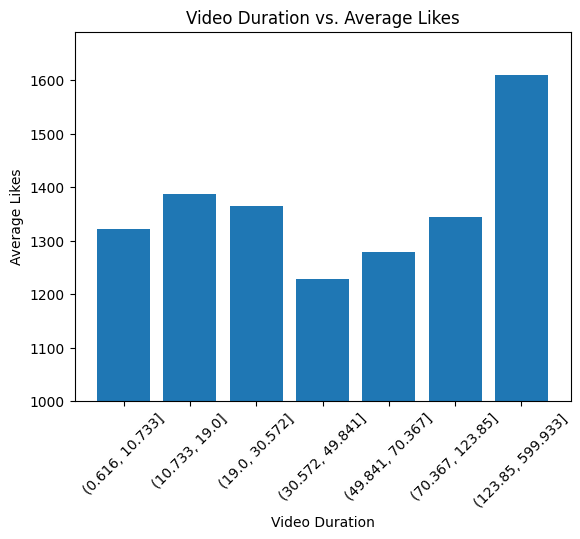

In [110]:
# Create a new column 'duration_bins' by cutting the 'vid_durations' into quantile-based bins
video_df["duration_bins"] = pd.qcut(vid_durations, q=7)

# Group by 'duration_bins' and calculate the mean likes for each bin
grouped = video_df.groupby("duration_bins")["likes"].mean()

# Plot the result
plt.bar(grouped.index.astype(str), grouped.values)
plt.xlabel("Video Duration")
plt.ylabel("Average Likes")
plt.title("Video Duration vs. Average Likes")
plt.ylim(1000)
plt.xticks(rotation=45)

,date,likes,content,username,media,inferred_company,content_length,media_type,duration_bins
0,2020-11-15 16:01:08,525,an 85yearold primary school in shanghai has be...,cnni,[{'variants': [{'url': 'https://video.twimg.co...,cnn,168,{'video'},"(62.136, 71.967]"
1,2018-07-17 22:04:26,3,next week cncf will be publishing a series of ...,CiscoCloud,[{'variants': [{'url': 'https://video.twimg.co...,cisco,196,{'video'},"(54.407, 59.459]"
2,2020-03-01 15:48:46,672,the ustaliban agreement which sets into motion...,CNN,[{'variants': [{'url': 'https://video.twimg.co...,cnn,263,{'video'},"(235.936, 599.933]"
3,2018-08-17 13:00:18,2,whilst is not found in the uk it can occur in ...,Pfizer_UK,[{'variants': [{'url': 'https://video.twimg.co...,pfizer,123,{'video'},"(21.73, 25.6]"
4,2019-04-16 16:49:47,233,wow what an experience complete with in flight...,townsendbell,[{'variants': [{'url': 'https://video.twimg.co...,bell,109,{'video'},"(5.6, 7.56]"
...,...,...,...,...,...,...,...,...,...
74780,2019-12-27 17:13:54,8,a man full of confidence mention with the nolo...,EuroLeague,[{'variants': [{'url': 'https://video.twimg.co...,turkish airlines,63,{'video'},"(18.44, 21.73]"
74781,2020-12-17 19:45:01,174,im incredibly pumped for alum mention hes been...,PatMcAfeeShow,[{'variants': [{'url': 'https://video.twimg.co...,mcafee,139,{'video'},"(166.571, 235.936]"
74782,2018-02-23 11:24:36,46,kjeld nuis of is golden again this time in the...,CBCOlympics,[{'variants': [{'url': 'https://video.twimg.co...,cbc,136,{'video'},"(18.44, 21.73]"
74783,2019-10-29 10:44:00,119,the us air forces mysterious space plane just ...,Independent,[{'variants': [{'url': 'https://video.twimg.co...,independent,148,{'video'},"(62.136, 71.967]"


/tmp/ipykernel_198194/1613410145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_df_1["duration_bins"] = pd.qcut(vid_durations, q=25)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, '(0.616, 5.6]'),
  Text(1, 0, '(5.6, 7.56]'),
  Text(2, 0, '(7.56, 10.0]'),
  Text(3, 0, '(10.0, 11.735]'),
  Text(4, 0, '(11.735, 14.4]'),
  Text(5, 0, '(14.4, 15.24]'),
  Text(6, 0, '(15.24, 18.44]'),
  Text(7, 0, '(18.44, 21.73]'),
  Text(8, 0, '(21.73, 25.6]'),
  Text(9, 0, '(25.6, 29.963]'),
  Text(10, 0, '(29.963, 31.898]'),
  Text(11, 0, '(31.898, 36.602]'),
  Text(12, 0, '(36.602, 42.555]'),
  Text(13, 0, '(42.555, 47.915]'),
  Text(14, 0, '(47.915, 54.407]'),
  Text(15, 0, '(54.407, 59.459]'),
  Text(16, 0, '(59.459, 62.136]'),
  Text(17, 0, '(62.136, 71.967]'),
  Text(18, 0, '(71.967, 84.1]'),
  Text(19, 0, '(84.1, 97.444]'),
  Text(20, 0, '(97.444, 115.616]'),
  Text(21, 0, '(115.616, 135.766]'),
  Text(22, 0, '(135.766, 166.571]'),
  Text(23, 0, '(166.571, 235.936]'),
  Text(24, 0, '(235.936, 599.933]')])

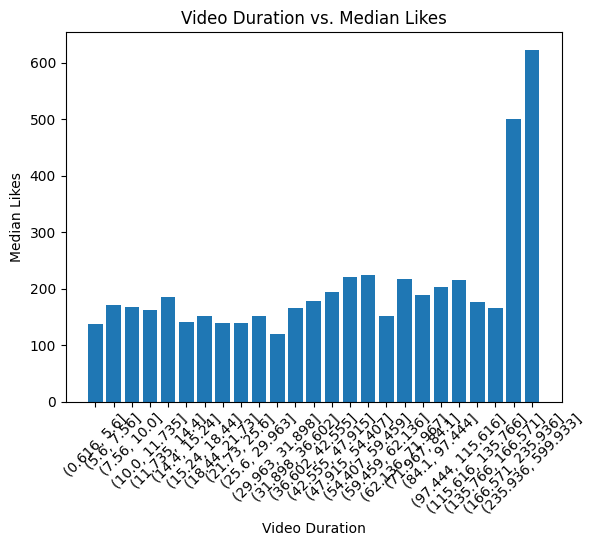

In [132]:
# Group by 'duration_bins' and calculate the median likes for each bin
# Create a new column 'duration_bins' by cutting the 'vid_durations' into quantile-based bins
video_df_1 = video_df[video_df['inferred_company'] != 'fc barcelona']
video_df_1["duration_bins"] = pd.qcut(vid_durations, q=25)
grouped = video_df_1.groupby("duration_bins")["likes"].median()
# Plot the result
plt.bar(grouped.index.astype(str), grouped.values)
plt.xlabel("Video Duration")
plt.ylabel("Median Likes")
plt.title("Video Duration vs. Median Likes")
plt.xticks(rotation=45)

154      [{'variants': [{'url': 'https://video.twimg.co...
347      [{'variants': [{'url': 'https://video.twimg.co...
1007     [{'variants': [{'url': 'https://video.twimg.co...
1029     [{'variants': [{'url': 'https://video.twimg.co...
1062     [{'variants': [{'url': 'https://video.twimg.co...
                               ...                        
73126    [{'variants': [{'url': 'https://video.twimg.co...
73496    [{'variants': [{'url': 'https://video.twimg.co...
74127    [{'variants': [{'url': 'https://video.twimg.co...
74187    [{'variants': [{'url': 'https://video.twimg.co...
74263    [{'variants': [{'url': 'https://video.twimg.co...
Name: media, Length: 224, dtype: object

<Axes: xlabel='inferred_company'>

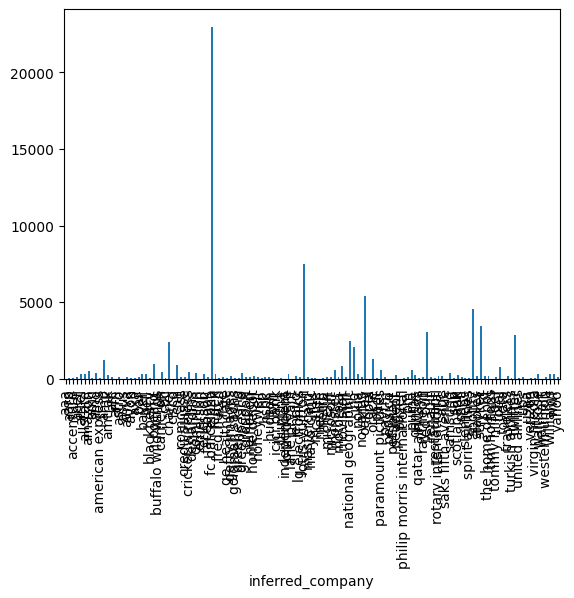

In [116]:
long_companies = video_df[vid_durations > 135]['inferred_company'].unique()
successful_companies = df[df['inferred_company'].isin(long_companies)].groupby('inferred_company')['likes'].median()
successful_companies.sort_values(ascending=False, inplace=True)
df[df['inferred_company'].isin(long_companies)].groupby('inferred_company')['likes'].median().plot(kind='bar')

<Axes: xlabel='inferred_company'>

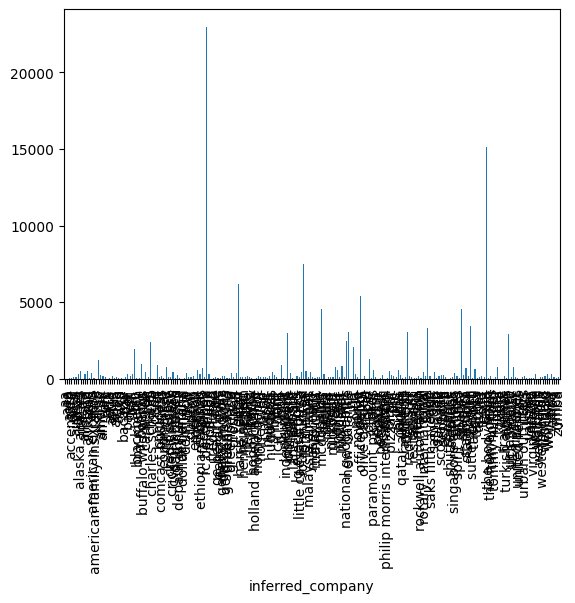

In [21]:
df.groupby('inferred_company')['likes'].median().plot(kind='bar')

In [48]:
df.head()

,date,likes,content,username,media,inferred_company,content_length,media_type
0,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[{'preview_url': 'https://pbs.twimg.com/media/...,tim hortons,181,{'photo'}
1,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[{'preview_url': 'https://pbs.twimg.com/media/...,independent,73,{'photo'}
2,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[{'preview_url': 'https://pbs.twimg.com/media/...,cbc,104,{'photo'}
3,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[{'preview_url': 'https://pbs.twimg.com/media/...,williams,140,{'photo'}
4,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[{'preview_url': 'https://pbs.twimg.com/media/...,independent,199,{'photo'}


In [49]:
df["media_type"] = df["media_type"].astype("category").cat.codes
df["inferred_company"] = df["inferred_company"].astype("category").cat.codes
df.head()

,date,likes,content,username,media,inferred_company,content_length,media_type
0,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[{'preview_url': 'https://pbs.twimg.com/media/...,190,181,4
1,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[{'preview_url': 'https://pbs.twimg.com/media/...,98,73,4
2,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[{'preview_url': 'https://pbs.twimg.com/media/...,37,104,4
3,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[{'preview_url': 'https://pbs.twimg.com/media/...,214,140,4
4,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[{'preview_url': 'https://pbs.twimg.com/media/...,98,199,4


<Axes: >

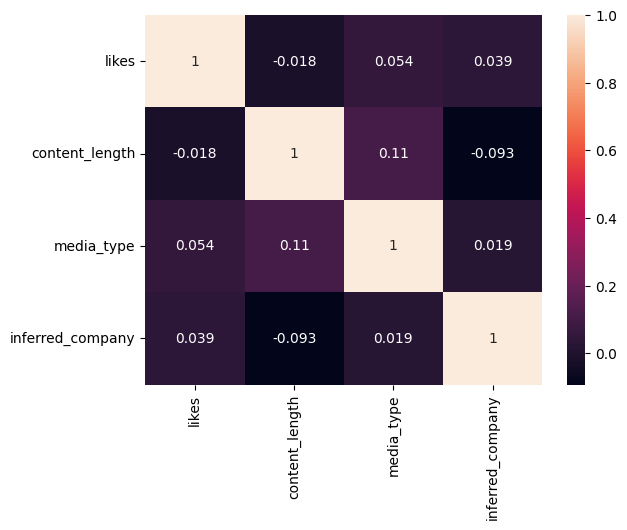

In [78]:
sns.heatmap(
    df[["likes", "content_length", "media_type", "inferred_company"]].corr(), annot=True
)

Text(0.5, 1.0, 'Scatter Plot of Likes vs. Content Length')

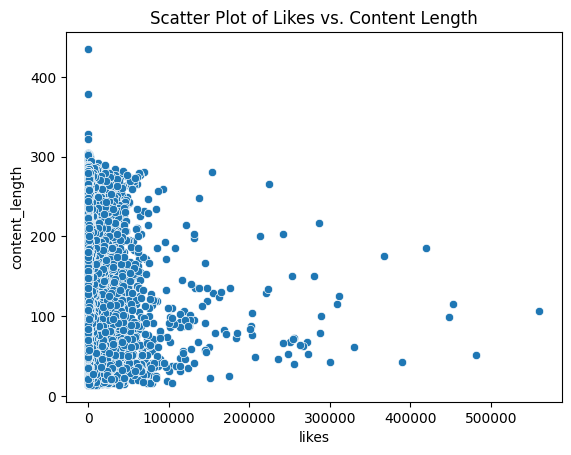

In [25]:
# Scatter plot
# Put plt.show() at the end to display the plot properly
sns.scatterplot(data=df, x="likes", y="content_length")
plt.title("Scatter Plot of Likes vs. Content Length")

Text(0.5, 1.0, 'Box Plot of Content Length')

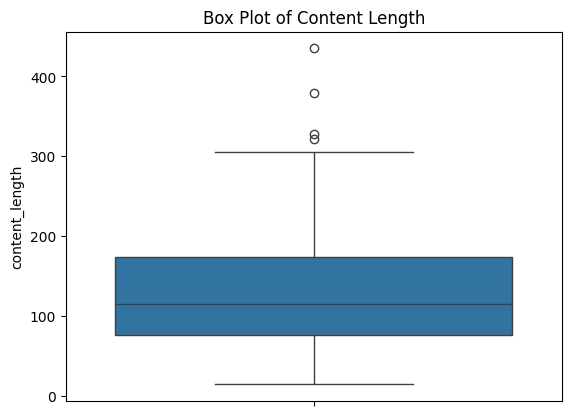

In [26]:
# Box plot
# Put plt.show() at the end to display the plot properly
sns.boxplot(data=df, y="content_length")
plt.title("Box Plot of Content Length")

Text(0.5, 1.0, 'Histogram of Content Length')

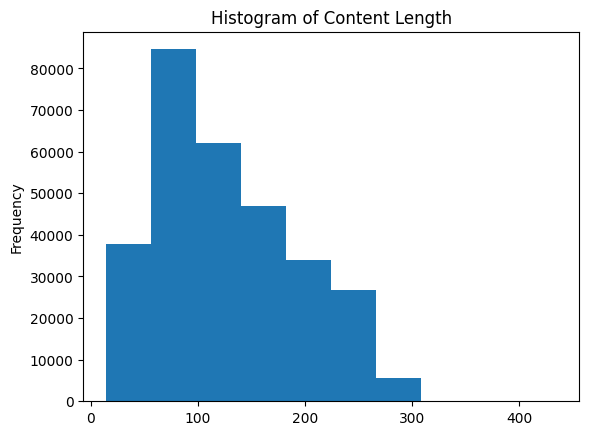

In [27]:
# Histogram
# Put plt.show() at the end to display the plot properly
df["content_length"].plot(kind="hist")
plt.title("Histogram of Content Length")

In [28]:
# Download the tokenizer
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/dvishal485/nltk_data...

[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
# Tokenize the text and calculate word frequency
all_words = " ".join(df["content"]).lower()
words = word_tokenize(all_words)
fdist = FreqDist(words)
print("Words with most frequency (top 30 words):")
print(fdist.most_common()[:30])

Words with most frequency (top 30 words):

[('hyperlink', 461718), ('the', 246351), ('to', 176651), ('mention', 129424), ('and', 115296), ('a', 113723), ('of', 107678), ('in', 101995), ('for', 82650), ('on', 65844), ('you', 56280), ('with', 56211), ('is', 56000), ('your', 47628), ('at', 46159), ('this', 41921), ('our', 36185), ('from', 29832), ('more', 29616), ('are', 29113), ('we', 29026), ('it', 27562), ('that', 25734), ('new', 23745), ('be', 22585), ('as', 20772), ('now', 20062), ('how', 19979), ('amp', 19783), ('by', 19358)]


In [40]:
# Sentiment analysis
df["sentiment"] = df["content"].apply(lambda x: TextBlob(x).sentiment.polarity)
print("Sentiment Analysis:")
df

Sentiment Analysis:


,date,likes,content,username,media,inferred_company,content_length,sentiment,topic
0,2020-12-12 00:47:00,1,spend your weekend morning with a ham egg and ...,TimHortonsPH,[{'preview_url': 'https://pbs.twimg.com/media/...,tim hortons,155,0.175000,1
1,2018-06-30 10:04:20,2750,watch rapper mention freestyle for over an hou...,IndyMusic,[{'preview_url': 'https://pbs.twimg.com/media/...,independent,67,0.000000,2
2,2020-09-29 19:47:28,57,canadian armenian community demands ban on mil...,CBCCanada,[{'preview_url': 'https://pbs.twimg.com/media/...,cbc,100,-0.100000,1
3,2020-10-01 11:40:09,152,1st in europe to be devastated by covid19 ital...,MKWilliamsRome,[{'preview_url': 'https://pbs.twimg.com/media/...,williams,125,0.500000,1
4,2018-10-19 14:30:46,41,congratulations to pauletha butts of mention s...,BGISD,[{'preview_url': 'https://pbs.twimg.com/media/...,independent,164,0.050000,2
...,...,...,...,...,...,...,...,...,...
297600,2019-09-07 16:18:10,0,barcelona star expected to return against vale...,IndependentNGR,[{'preview_url': 'https://pbs.twimg.com/media/...,independent,70,-0.100000,1
297601,2018-02-23 11:24:36,46,kjeld nuis of is golden again this time in the...,CBCOlympics,[{'variants': [{'url': 'https://video.twimg.co...,cbc,136,0.150000,2
297602,2020-11-11 20:18:15,261,grateful to have mention officially join menti...,TeamCoachBuzz,[{'preview_url': 'https://pbs.twimg.com/media/...,williams,58,0.000000,2
297603,2019-10-29 10:44:00,119,the us air forces mysterious space plane just ...,Independent,[{'variants': [{'url': 'https://video.twimg.co...,independent,148,0.000000,2


In [31]:
# Topic modeling (Example using Latent Dirichlet Allocation)

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["content"])

In [32]:
# Topic modeling (Example using Latent Dirichlet Allocation)
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(X)

LatentDirichletAllocation(n_components=2, random_state=0)

In [34]:
print("Topics identified by LDA:")
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-5:]])

Topics identified by LDA:

Topic 0:

['and', 'to', 'mention', 'the', 'hyperlink']

Topic 1:

['in', 'of', 'to', 'the', 'hyperlink']


In [35]:
# Tokenize the text data
cv = CountVectorizer()
tfidf = TfidfTransformer()
text_counts = cv.fit_transform(df["content"])
text_tfidf = tfidf.fit_transform(text_counts)

In [36]:
# Apply Latent Dirichlet Allocation for topic modeling
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_output = lda_model.fit_transform(text_tfidf)

In [37]:
# Find characteristic examples relevant to desired outcomes
topic_keywords = []
for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:5]
    topic_keywords.append([cv.get_feature_names_out()[i] for i in top_keyword_locs])

In [38]:
for idx, topic_keywords in enumerate(topic_keywords):
    print(f"\nTopic {idx+1} keywords:")
    print(topic_keywords)



Topic 1 keywords:

['hyperlink', 'the', 'to', 'and', 'in']



Topic 2 keywords:

['hyperlink', 'mention', 'the', 'to', 'you']


In [39]:
# Extract characteristic examples that are relevant to desired outcomes
topic_results = lda_model.transform(text_tfidf)
df["topic"] = topic_results.argmax(axis=1) + 1
for topic in range(1, 3):
    print(f"\nCharacteristic examples for Topic {topic}:")
    # Display top 3 characteristic examples per topic
    print(df[df["topic"] == topic]["content"].values[:3])



Characteristic examples for Topic 1:

['spend your weekend morning with a ham egg and cheese wrap paired with a sweet iced french vanilla order yours now via dinein takeout and delivery hyperlink'

 'canadian armenian community demands ban on military drone tech exports to turkey hyperlink hyperlink'

 '1st in europe to be devastated by covid19 italy redoubled its efforts and theyre now paying off my latest hyperlink hyperlink']



Characteristic examples for Topic 2:

['watch rapper mention freestyle for over an hour hyperlink hyperlink'

 'congratulations to pauletha butts of mention she was presented a beyond the call award for her leadership and planning last weeks cultural diversity night hyperlink'

 'an 85yearold primary school in shanghai has been lifted off the ground in its entirety and relocated using new technology dubbed the walking machine hyperlink hyperlink']
